In [81]:
#from pyscf import gto, scf, fci, lo
#import netket as nk; import netket.experimental as nkx
import numpy as np
import time
#import itertools
import qiskit
#from qiskit.quantum_info import Pauli, SparsePauliOp
from collections import defaultdict
#import tensorflow as tf
import sys
import os
import pandas as pd
#import itertools
from itertools import product
import matplotlib.pyplot as plt
#sys.path.append(os.path.dirname(os.getcwd()) + "/SAMPLER_LOCAL_IMPORT")
#from Sampling_Quantum import *
#from New_MCMC_Proposal import *
#sys.path.append(os.getcwd() + "/Code_download_Bell_2")
from MCMC_funs_Leyden import *

print(qiskit.version.get_version_info())
os.getcwd()

1.0.2


"c:\\Users\\vinit\\Downloads\\Research\\Quantum-Sampling\\Manas' Proposals"

In [82]:
def plot_sample_dict(prob_dict, label=''): 
    sorted_keys = sorted(prob_dict.keys(), key=lambda k: spinconf2int(np.array(k)))
    sorted_ints = [spinconf2int(np.array(k)) for k in sorted_keys]
    sorted_vals = [prob_dict[k] for k in sorted_keys]
    plt.plot(sorted_ints, sorted_vals, label=label)

In [83]:
#Cluster_update_scheme (Swedson-Wang /Wolff type + Local Exchange)
#*****************************************************************


def all_configs(n):
    return [np.array(v) for v in product([-1, 1], repeat=n)]



def Sampling_MCMC_trajectories(problem_inst, Transition_matrix, sample_size=10000, 
                               burn=1000, method='Quantum', init_config=None):

    n = problem_inst.n
    beta = problem_inst.T
    prob_dist = np.zeros(2**n)

    #exact_dist = np.exp(-beta * Proposal_object.Energy_array)
    #exact_dist = exact_dist / np.sum(exact_dist)

    #err_hist = []
    key_list = []

    if init_config==None:
        s = np.random.choice([1,-1],size=n)
    else: s = init_config

    int_key = spinconf2int(s)
    #print(int_key)
    
    for k in range(burn):
        #s = Proposal_object.generate_MCMC_trajectories(Transition_matrix, s)
         int_key = generate_move(transition_mat=Transition_matrix, state=int_key)

    for k in range(sample_size):
        #s = Proposal_object.generate_MCMC_trajectories(Transition_matrix, s)
        int_key = generate_move(transition_mat=Transition_matrix, state=int_key)
        #key = spinconf2int(s)
        prob_dist[int_key] +=1
        key_list.append(int_key)

    
    return np.flip(prob_dist/np.sum(prob_dist)), key_list


def wolff_clustering_flipping_step(v, beta, J, num_trials=200):
    from collections import defaultdict
    n = len(v)
    counts = defaultdict(int)

    for i in range(n):  # Seed spin
        for _ in range(num_trials):
            visited = np.zeros(n, dtype=bool)
            cluster = [i]
            visited[i] = True

            while cluster:
                j = cluster.pop()
                for k in range(n):
                    #print(f"Checking {j} and {k}", visited[k], v[k], v[j], J[j, k])
                    if not visited[k] and v[k] == v[j] and J[j, k] > 0:
                        p_add = 1 - np.exp(-2 * beta * J[j, k])
                        if np.random.rand() < p_add:
                            visited[k] = True
                            cluster.append(k)
                        #print(f"\t\t Adding {k} to cluster", cluster, p_add)
            #print(f"Visited: {visited}, Seed: {i}, Cluster size: {np.sum(visited)}")
            
            v_new = v.copy()
            v_new[visited] *= -1
            counts[tuple(v_new)] += 1

            #print("\n\n", i, visited, v_new, counts[tuple(v_new)], "\n\n")

    total = sum(counts.values())
    return {k: c / total for k, c in counts.items()}




In [84]:
def enumerate_clusters(s, J, seed, beta=1.0, prob_threshold=1e-12):
    """
    Enumerate all Wolff clusters reachable from a seed, returning
    {frozenset(cluster_sites): probability}.
    """
    n = len(s)
    spins = np.asarray(s)
    J = np.asarray(J)

    def p_add(i, j):
        return (1 - np.exp(-2 * beta * J[i, j])) if (J[i, j] > 0 and spins[i] == spins[j]) else 0.0

    clusters = {}

    # Represent the search state by (cluster_set, frontier_edges, tested_edges)
    # frontier_edges: list of directed edges (u, v) with u in cluster, v possibly outside;
    # tested_edges: set of frozensets({u, v}) so each undirected bond is branched once.
    def search(cluster, frontier, tested, p_accum):
        if p_accum < prob_threshold:
            return
        if not frontier:
            fs = frozenset(cluster)
            clusters[fs] = clusters.get(fs, 0.0) + p_accum
            return

        u, v = frontier[0]
        rest = frontier[1:]
        e = frozenset((u, v))
        if e in tested:  # already branched on this bond (shouldn’t happen, but guard)
            search(cluster, rest, tested, p_accum)
            return

        # Branch 1: bond (u, v) does NOT activate
        p_off = 1.0 - p_add(u, v)
        if p_off > 0:
            search(cluster, rest, tested | {e}, p_accum * p_off)

        # Branch 2: bond (u, v) activates -> add v to cluster, add new edges out of v
        p_on = p_add(u, v)
        if p_on > 0:
            if v in cluster:
                # v already present (can happen if another bond added it earlier); just mark bond tested
                search(cluster, rest, tested | {e}, p_accum * p_on)
            else:
                new_cluster = tuple(sorted(cluster + (v,)))
                new_frontier = list(rest)

                # Add all edges (v, w) for like-spin, ferromagnetic neighbors w != v
                for w in range(n):
                    if w == v:
                        continue
                    if spins[w] != spins[v] or J[v, w] <= 0:
                        continue
                    ee = frozenset((v, w))
                    # Only add if this undirected edge hasn't been tested yet AND isn't already queued
                    if ee not in tested and all(frozenset((a, b)) != ee for (a, b) in new_frontier):
                        new_frontier.append((v, w))

                search(new_cluster, new_frontier, tested | {e}, p_accum * p_on)

    # Seed cluster and initial frontier: all bonds from seed to aligned, J>0 neighbors
    init_cluster = (seed,)
    init_frontier = [(seed, j) for j in range(n) if j != seed and J[seed, j] > 0 and s[j] == s[seed]]
    search(init_cluster, init_frontier, set(), 1.0)
    return clusters


In [92]:
def wolff_transition_probabilities(s, J, beta, prob_threshold=1e-8):
    """
    For a given spin configuration s (±1), enumerate all possible s' produced by Wolff updates,
    and their total probabilities (averaged over all seeds).
    Returns: dict mapping tuple(s') -> probability
    """
    n = len(s)
    s_to_prob = defaultdict(float)
    for seed in range(n):
        cluster_probs = enumerate_clusters(s, J, seed, beta, prob_threshold)
        #print(seed, cluster_probs)
        for cluster, prob in cluster_probs.items():
            s_prime = s.copy()
            for i in cluster:
                s_prime[i] *= -1
            s_to_prob[tuple(s_prime)] += prob / n  # average over all seeds
    # Normalize (should sum to 1)
    norm = sum(s_to_prob.values())
    for key in s_to_prob:
        s_to_prob[key] /= norm
    return dict(s_to_prob)

In [93]:
filepath = '/Users/vinit/Downloads/Research/Quantum-Sampling/Manas\' Proposals/'
filename_instances =  '/instances_new.pkl'

instances = pd.read_pickle(filepath + filename_instances)

cond  = (instances['Instance Number']==8)
n = instances[cond]['Spins'].values[0]
J = instances[cond]['J'].values[0]
h = instances[cond]['h'].values[0]
    
problem_inst = ProblemInstance(J, h)
problem_inst.T = 1
n

10

Time taken for analytical: 0.02202296257019043
Time taken for sampling: 0.5163533687591553


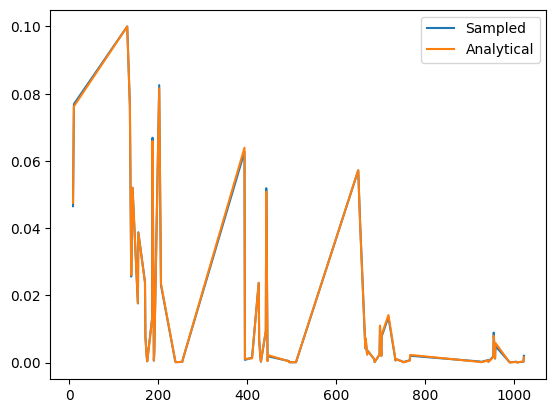

In [94]:
J_Q = problem_inst.J_quantum
J_Q = (J_Q + J_Q.T)   # Ensure symmetry
n = problem_inst.n
beta = problem_inst.T

configs = all_configs(n)
index = {tuple(c): i for i, c in enumerate(configs)}

Q = np.zeros((2**n, 2**n))

v = np.random.choice([1,-1],size=n)  

tm = time.time()
analytical = wolff_transition_probabilities(s=v, 
                              J=J_Q, beta=1, prob_threshold=1e-8)
print("Time taken for analytical:", time.time() - tm)

tm = time.time()
sampled = wolff_clustering_flipping_step(v, beta=1, J=J_Q, num_trials=4000)
print("Time taken for sampling:", time.time() - tm)


plot_sample_dict(sampled, label='Sampled')
plot_sample_dict(analytical, label='Analytical')
plt.legend()


[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1] 4000
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1] 6000
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1] 8000


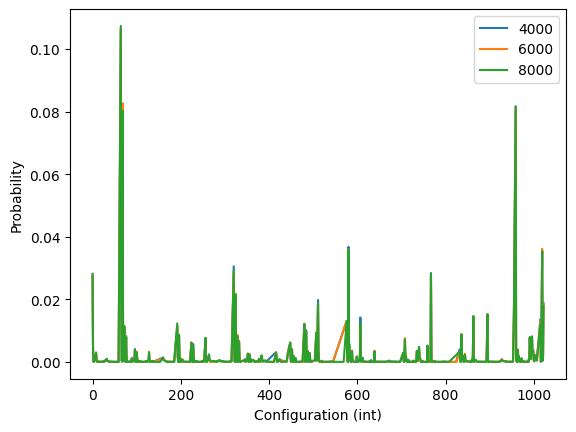

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [95]:

def Wolff_cluster_Proposal_matrix(problem_inst):
    J_Q = problem_inst.J_quantum
    if np.linalg.norm(J_Q - J_Q.T) > 1e-8:
        print("Warning: J_Q is not symmetric, correcting...")
        J_Q = (J_Q + J_Q.T)  # Ensure symmetry

    n = problem_inst.n
    beta = problem_inst.T

    configs = all_configs(n)
    index = {tuple(c): i for i, c in enumerate(configs)}

    Q = np.zeros((2**n, 2**n))

    for v in configs:   
        for num_trials in np.arange(4000, 10000, 2000):
            
            prop_probs = wolff_clustering_flipping_step(v, beta=beta, J=J_Q, num_trials=num_trials)
            print(v, num_trials)

            plot_sample_dict(prop_probs, label=str(num_trials))
        plt.xlabel('Configuration (int)')
        plt.ylabel('Probability')
        plt.legend()
        plt.show()
        break

        i = index[tuple(v)]
        for v_prime, prob in prop_probs.items():
            j = index[v_prime]
            if j != i :
                Q[j, i] = abs(prob)
        
        Q[i, i] = abs(1- sum(Q[:,i]))

    return Q

Wolff_cluster_Proposal_matrix(problem_inst=problem_inst)

In [167]:

def Wolff_cluster_Proposal_matrix(problem_inst, num_trials=4000):
    J_Q = -problem_inst.J_quantum  # Note the negative sign; it is added for convention consistency
    if np.linalg.norm(J_Q - J_Q.T) > 1e-8:
        print("Warning: J_Q is not symmetric, correcting...")
        J_Q = (J_Q + J_Q.T)  # Ensure symmetry

    n = problem_inst.n
    beta = problem_inst.T

    configs = all_configs(n)
    index = {tuple(c): i for i, c in enumerate(configs)}

    Q = np.zeros((2**n, 2**n))

    for v in configs:   

        #prop_probs = wolff_clustering_flipping_step(v, beta=beta, J=J_Q, num_trials=num_trials)
        prop_probs = wolff_transition_probabilities(s=v, 
                            J=J_Q, beta=1, prob_threshold=1e-8)

        i = index[tuple(v)]
        for v_prime, prob in prop_probs.items():
            j = index[v_prime]
            if j != i :
                Q[j, i] = abs(prob)
        
        Q[i, i] = abs(1- sum(Q[:,i]))

    return Q

Starting problem instance 1 of 5 with n = 3
Time taken to compute proposal matrix: 0.0
Instance 1, T = 1, Proposal = Wolff_cluster_update, Acceptance = metropolis, Gap = 0.2002
Time taken to sample: 0.0837256908416748


C:\Users\vinit\AppData\Local\Temp\ipykernel_36472\3791985995.py:72: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results,pd.DataFrame([results_datum])], ignore_index=True)


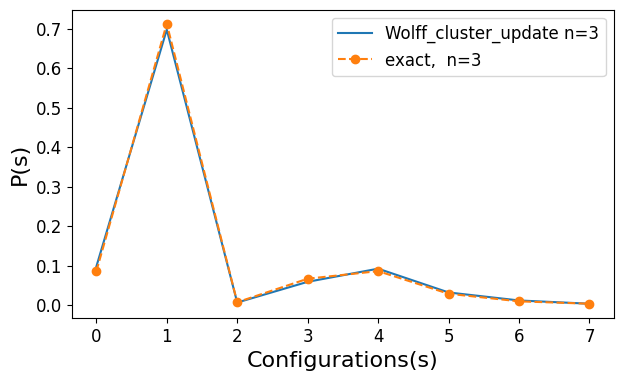

Starting problem instance 2 of 5 with n = 4
Time taken to compute proposal matrix: 0.00469517707824707
Instance 2, T = 1, Proposal = Wolff_cluster_update, Acceptance = metropolis, Gap = 0.2905
Time taken to sample: 0.058324575424194336


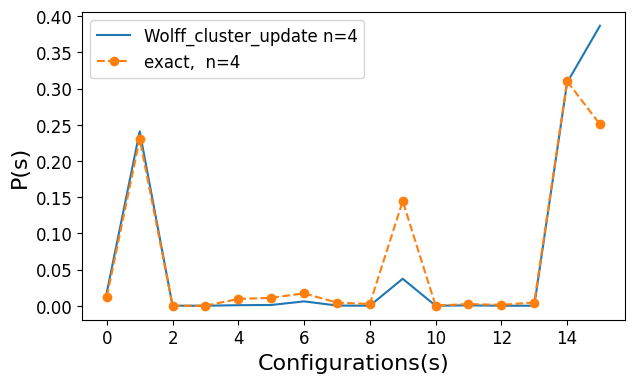

Starting problem instance 3 of 5 with n = 5
Time taken to compute proposal matrix: 0.021278858184814453
Instance 3, T = 1, Proposal = Wolff_cluster_update, Acceptance = metropolis, Gap = 0.2047
Time taken to sample: 0.04886889457702637


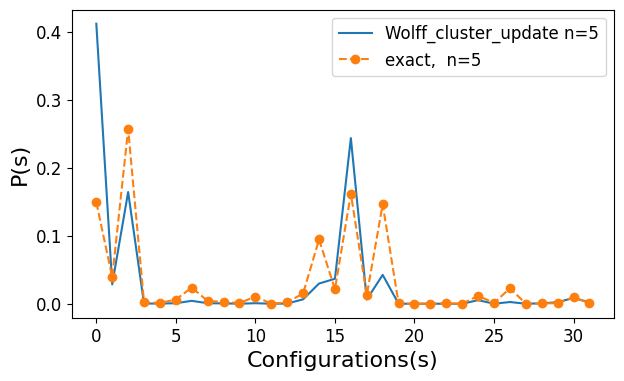

Starting problem instance 4 of 5 with n = 6
Time taken to compute proposal matrix: 0.025309085845947266
Instance 4, T = 1, Proposal = Wolff_cluster_update, Acceptance = metropolis, Gap = 0.0292
Time taken to sample: 0.04157900810241699


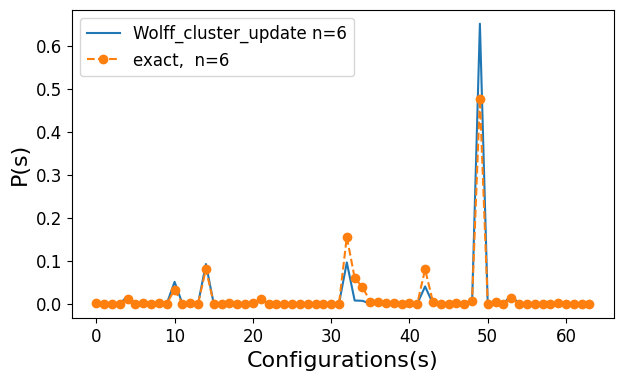

Starting problem instance 5 of 5 with n = 7
Time taken to compute proposal matrix: 0.39804840087890625
Instance 5, T = 1, Proposal = Wolff_cluster_update, Acceptance = metropolis, Gap = 0.0507
Time taken to sample: 0.05910491943359375


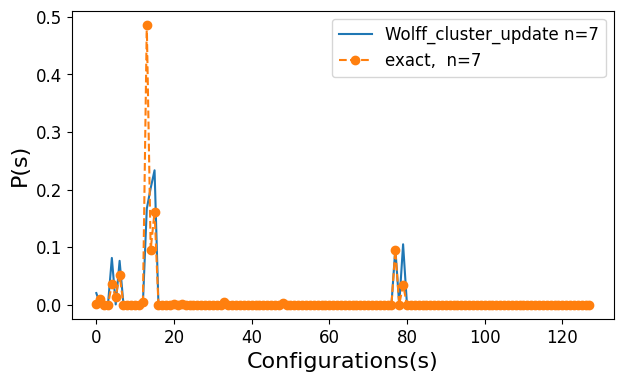

In [ ]:
filepath = '/Users/vinit/Downloads/Research/Quantum-Sampling/Manas\' Proposals/'
filename_instances =  '/instances_new.pkl'
sample_size=4000

instances = pd.read_pickle(filepath + filename_instances)
tot_instances = np.max(instances['Instance Number'].values)
#tot_instances = 5
results = pd.DataFrame(columns = [
    'Instance Number',
    'Spins', 
    'Temperature', 
    'Connectivity',
    'Proposal',
    'Acceptance',
    'Gap',
    'Gap Lazy'
        ])
T_logmesh = np.logspace(-3, 3, 50)
T_round = np.sort( np.kron(np.array([1,5]), 10.**np.arange(-3,4)))
T_lim = np.array([0, np.inf]) 
T_arr = np.unique( np.concatenate((T_logmesh, T_round, T_lim))) 
#T_arr = np.delete(T_arr, -2) 
T_arr = [1]
delta_step = 0.2


for instance_num in range(1, tot_instances+1):
    cond  = (instances['Instance Number']==instance_num)
    n            = instances[cond]['Spins'].values[0]
    connectivity = instances[cond]['Connectivity'].values[0]
    # pr = np.log(2)/2
    # J = -(np.triu(np.ones((n,n)), k=1)) * pr
    J            = instances[cond]['J'].values[0]
    h            = instances[cond]['h'].values[0]

    print('Starting problem instance', instance_num, 'of', tot_instances, 'with n =', n)

    problem_inst = ProblemInstance(J, h)


    for T in T_arr:
        problem_inst.T = T
        proposal_mats={}
        tm = time.time()
        proposal_mats['Wolff_cluster_update'] = Wolff_cluster_Proposal_matrix(problem_inst)
        print("Time taken to compute proposal matrix:", time.time() - tm)   

        prop_type = 'Wolff_cluster_update'
        accept_type = 'metropolis'

        transition_mat = make_transition_mat(problem_inst, proposal_mats[prop_type], acceptance=accept_type)   #proposal_mats['Wolff_cluster_update'] 
        
        gap, _ = abs_spectral_gap(transition_mat)

        results_datum = {
            'Instance Number': instance_num,
            'Spins': n, 
            'Temperature': T, 
            'Connectivity': connectivity,
            'Proposal': prop_type,
            'Acceptance': accept_type,
            'Mismatched': False,
            'Gap': gap,
            "delta_time_step_Trotter": delta_step
        }

        #print(results_datum)

        print("Instance {}, T = {}, Proposal = {}, Acceptance = {}, Gap = {:.4f}".format(
            instance_num, T, prop_type, accept_type, gap))
        
        results = pd.concat([results,pd.DataFrame([results_datum])], ignore_index=True)

        tm = time.time()
        empirical_dist, key_list = Sampling_MCMC_trajectories(problem_inst, 
                                            Transition_matrix=transition_mat, sample_size=sample_size, burn=sample_size//10)

        print("Time taken to sample:", time.time() - tm)

        fig, ax = plt.subplots(1, figsize=(7,4))
        if prop_type == 'quantum_time_mid_gamma_mid_Trotter':
            prop_type = 'quantum_circ'
        ax.plot(empirical_dist, label=prop_type + ' n={}'.format(problem_inst.n))
        exact_dist = np.exp(-problem_inst.T*problem_inst.E_arr[::-1])
        exact_dist = exact_dist / np.sum(exact_dist)

        ax.plot(exact_dist, marker='o', linestyle='dashed', label='exact,  n={}'.format(problem_inst.n))
        
        ax.set_xlabel("Configurations(s)", fontsize=16)
        ax.set_ylabel("P(s)", fontsize=16)
        ax.legend(loc='best', fontsize=12)
        ax.tick_params(axis='both', which='major', labelsize=12)
        plt.savefig(os.getcwd() + "/Figures/{}_vs_configs_n_{}.png".format(prop_type, problem_inst.n), bbox_inches='tight')
        plt.show()

        results.to_csv('results_all_prop.csv', mode='a', header=not os.path.exists('results_all_prop.csv'), index=False)

results.to_pickle('results_new_all_prop.pkl')

In [171]:
np.exp(problem_inst.T*problem_inst.E_arr[::-1])

array([8.51347637e-03, 1.31971963e-01, 1.32153714e+01, 4.36724691e+01,
       2.50724465e+00, 2.45862581e+00, 1.09393844e+00, 2.28687400e-01,
       2.28687400e-01, 1.09393844e+00, 2.45862581e+00, 2.50724465e+00,
       4.36724691e+01, 1.32153714e+01, 1.31971963e-01, 8.51347637e-03])

In [172]:
problem_inst.E_arr

array([-4.76610492, -2.02516578,  2.58138065,  3.77671791,  0.9191844 ,
        0.89960258,  0.08978443, -1.47539927, -1.47539927,  0.08978443,
        0.89960258,  0.9191844 ,  3.77671791,  2.58138065, -2.02516578,
       -4.76610492])

In [173]:
J + J.T

array([[-0.        , -0.10829303, -1.24312093, -0.29393886],
       [-0.10829303, -0.        , -2.04422139, -0.69013024],
       [-1.24312093, -2.04422139, -0.        , -0.38640047],
       [-0.29393886, -0.69013024, -0.38640047, -0.        ]])

In [174]:
np.sum(proposal_mats['Wolff_cluster_update'],axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [175]:
np.round(proposal_mats['Wolff_cluster_update'],3)

array([[0.   , 0.25 , 0.25 , 0.228, 0.25 , 0.331, 0.48 , 0.597, 0.25 ,
        0.185, 0.429, 0.441, 0.078, 0.248, 0.638, 0.801],
       [0.029, 0.   , 0.   , 0.136, 0.   , 0.084, 0.   , 0.088, 0.   ,
        0.157, 0.   , 0.147, 0.   , 0.017, 0.   , 0.074],
       [0.001, 0.   , 0.   , 0.136, 0.   , 0.   , 0.01 , 0.007, 0.   ,
        0.   , 0.035, 0.014, 0.   , 0.   , 0.   , 0.001],
       [0.   , 0.001, 0.053, 0.   , 0.   , 0.   , 0.   , 0.003, 0.   ,
        0.   , 0.   , 0.022, 0.   , 0.   , 0.   , 0.   ],
       [0.003, 0.   , 0.   , 0.   , 0.   , 0.084, 0.01 , 0.003, 0.   ,
        0.   , 0.   , 0.   , 0.211, 0.053, 0.014, 0.005],
       [0.004, 0.008, 0.   , 0.   , 0.086, 0.   , 0.   , 0.005, 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.133, 0.   , 0.005],
       [0.01 , 0.   , 0.071, 0.   , 0.019, 0.   , 0.   , 0.046, 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.03 , 0.004],
       [0.045, 0.057, 0.176, 0.211, 0.02 , 0.035, 0.157, 0.   , 0.   ,
        0.   , 0.   , 0.  

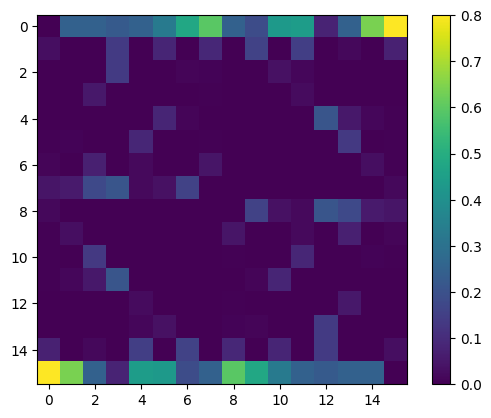

In [176]:
plt.imshow(proposal_mats['Wolff_cluster_update'])
plt.colorbar()

In [ ]:
results.to_csv('results_all_prop.csv', mode='a', header=not os.path.exists('results_all_prop.csv'), index=False)